## Setting up environment

In [1]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import tensorflow as tf
print('Check my GPU', tf.config.list_physical_devices('GPU'))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## Load Dataset and check it

In [4]:
(X_train, y_train), (_,_) = keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
print("Data shape:", X_train.shape)

Data shape: (60000, 28, 28)


In [6]:
y_train = y_train.reshape(-1, )
y_train[:5]

array([9, 0, 0, 3, 0], dtype=uint8)

In [7]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [8]:
def plot_images(X, y, index):
  plt.figure(figsize=(4, 4))
  plt.imshow(X[index], cmap="gray")
  plt.xlabel(classes[y[index]])

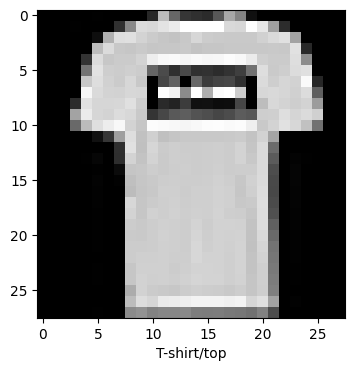

In [9]:
plot_images(X_train, y_train, 1)

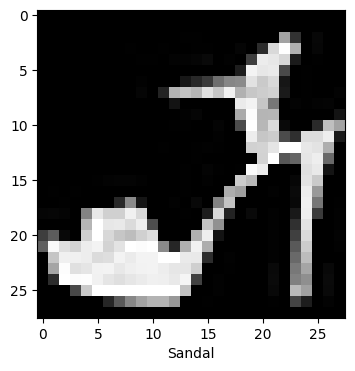

In [10]:
plot_images(X_train, y_train, 9)

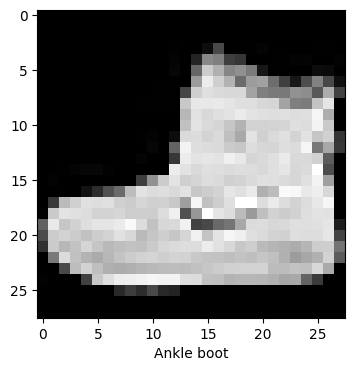

In [11]:
plot_images(X_train, y_train, 0)

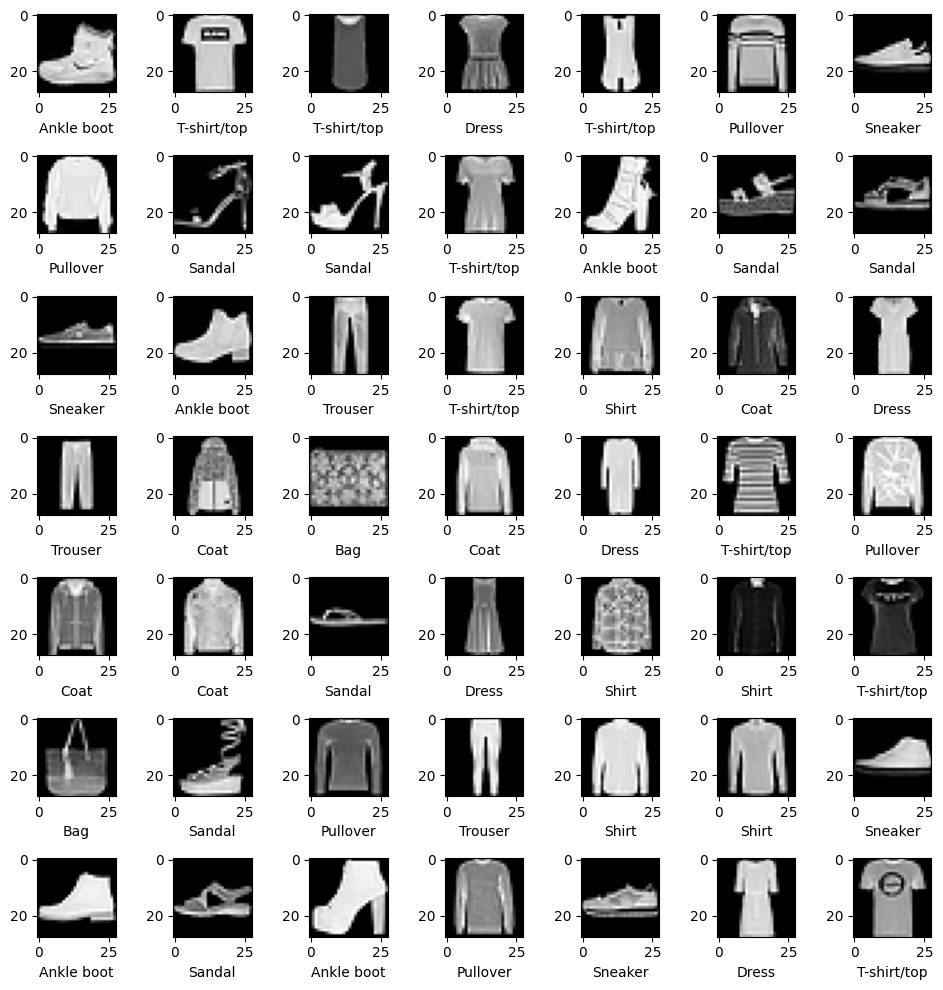

In [27]:
plt.figure(figsize=(10, 10))
for i in range(49):
  plt.subplot(7, 7, i+1)
  plt.imshow(X_train[i], cmap="gray")
  plt.xlabel(classes[y_train[i]])
  plt.tight_layout()
  plt.savefig("real.png")
plt.show()

## Create a data pipeline

In [13]:
#normalize and reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32")
X_train = (X_train - 127.5) / 127.5

In [14]:
#set bffer size for shuffling and batch size for slicing
BUFFER_SIZE = 60000
BATCH_SIZE =  256

In [15]:
# create the tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
#set latent dimension (to input noise vector) and weight unit randomly(default = mean(0.0), stddev(0.05))
LATENT_DIM = 100
WEIGHT_INIT = keras.initializers.RandomNormal(mean = 0.01, stddev = 0.02)

## Ceate a Generator and a Discriminator

In [17]:
# build our discriminator
def build_discriminator():
  model = keras.Sequential([
      # First COnv2d layer: Detect low level features in the images (edges, textures, ...)
      layers.Conv2D(64, (6,6), strides=(2,2), padding='same', input_shape=[28,28,1]),

      # LeakyRelu activation function to avoid dead neurons and allow negative gradients
      layers.LeakyReLU(0.2),
      # dropout to prevent overfitting and improve generalization
      layers.Dropout(0.3),

      # First COnv2d layer: learn more complex feature from the images
      layers.Conv2D(128, (6, 6), strides=(2,2), padding='same'),
      layers.LeakyReLU(0.2),
      layers.Dropout(0.3),

      # Flatten the 2D feature maps into a 1D vector for the Dense layer
      layers.Flatten(),
      layers.Dense(1, activation='sigmoid')

  ])

  return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 303,681 (1.16 MB)

 Trainable params: 303,681 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
def build_generator():
  model = keras.Sequential([
    layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)),
    layers.BatchNormalization(), # normalize the activation of the previous layer
    layers.LeakyReLU(),

    layers.Reshape((7, 7, 256)),

    layers.Conv2DTranspose(128, (6, 6), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(128, (6, 6), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),

    layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
  ])
  return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │       1,179,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 128)         │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │           1,152 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,076,224 (11.73 MB)

 Trainable params: 3,050,624 (11.64 MB)

 Non-trainable params: 25,600 (100.00 KB)

## Create the generator and discriminator loss

In [19]:
#create the discriminator and generator loss
cross_entropy = keras.losses.BinaryCrossentropy()

  # Create the discriminator loss
def discriminator_loss(real_output, fake_output):
  # calculates the loss when the discriminator classify fake images
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)

  #ccalculate the loss when the discriminator classifies fake images
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

 # Return the sum of both losses
  return real_loss + fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

## Building the sub class model

In [20]:
#create optimizer
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5)

In [21]:
# Building our sub ckass model
class GAN(keras.Model):
  def __init__(self, generator, discriminator):
    # initilize the GAN model  with the generator and discriminator
    super(GAN, self).__init__()
    self.generator = generator #set genrator model
    self.discriminator = discriminator # set discriminator moel


  def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
    super(GAN, self).compile()
    self.g_optimizer = g_optimizer # set the generator optimizer
    self.d_optimizer = d_optimizer # set the discriminator optimizer
    self.g_loss = g_loss # set the generator loss
    self.d_loss = d_loss # set the discriminator loss


  def train_step(self, real_images):
    # Training logic
    batch_size = tf.shape(real_images)[0]

    # Train discriminator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as d_tape:
        generated_images = self.generator(noise)
        #real_images += 0.1 * tf.random.normal(tf.shape(real_images))
        real_output = self.discriminator(real_images)
        fake_output = self.discriminator(generated_images)
        d_loss = self.d_loss(real_output, fake_output)

    # Cimputing the gradients for the discriminator based in its loss
    d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
    self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

     # Train generator
    noise = tf.random.normal([batch_size, LATENT_DIM])
    with tf.GradientTape() as g_tape:
        generated_images = self.generator(noise)
        fake_output = self.discriminator(generated_images)
        g_loss = self.g_loss(fake_output)

    g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
    self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_loss": g_loss}

In [22]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_images=16, latent_dim=100):
    self.num_images = num_images
    self.latent_dim = latent_dim
    self.seed = tf.random.normal([num_images, latent_dim])

  def on_epoch_end(self, epoch, logs=None):
    if epoch % 5 == 0:
      generated_images = self.model.generator(self.seed)
      generated_images = (generated_images * 127.5) + 127.5

      plt.figure(figsize=(8,8))
      for i in range(self.num_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i].numpy().astype("uint8"), cmap = "gray")
        plt.axis("off")
      plt.show()

## Train Dataset

In [23]:
#GAN MODEL
gan = GAN(generator=generator, discriminator = discriminator)

## COMPILE MODEL

gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
    )

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.3625 - g_loss: 0.7625

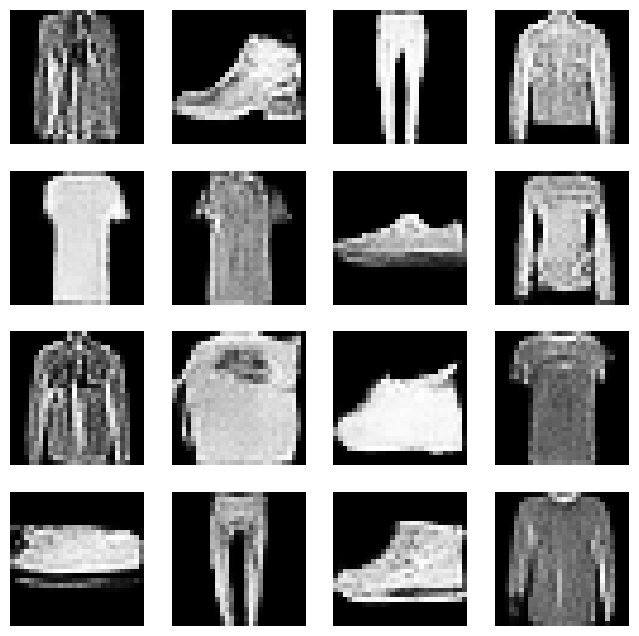

235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 122ms/step - d_loss: 1.3624 - g_loss: 0.7625
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - d_loss: 1.3590 - g_loss: 0.7514
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 131ms/step - d_loss: 1.3583 - g_loss: 0.7515
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - d_loss: 1.3614 - g_loss: 0.7584
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3604 - g_loss: 0.7589
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - d_loss: 1.3601 - g_loss: 0.7493

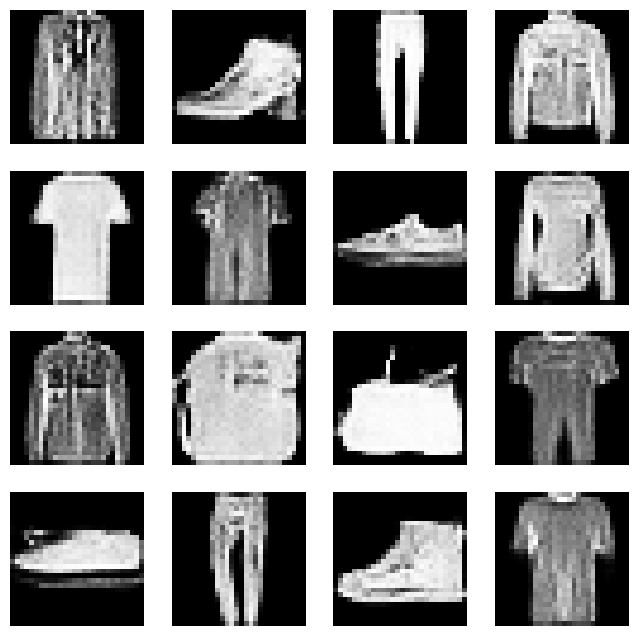

235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3602 - g_loss: 0.7493
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - d_loss: 1.3577 - g_loss: 0.7477
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3594 - g_loss: 0.7519
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3615 - g_loss: 0.7570
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3595 - g_loss: 0.7509
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - d_loss: 1.3607 - g_loss: 0.7547

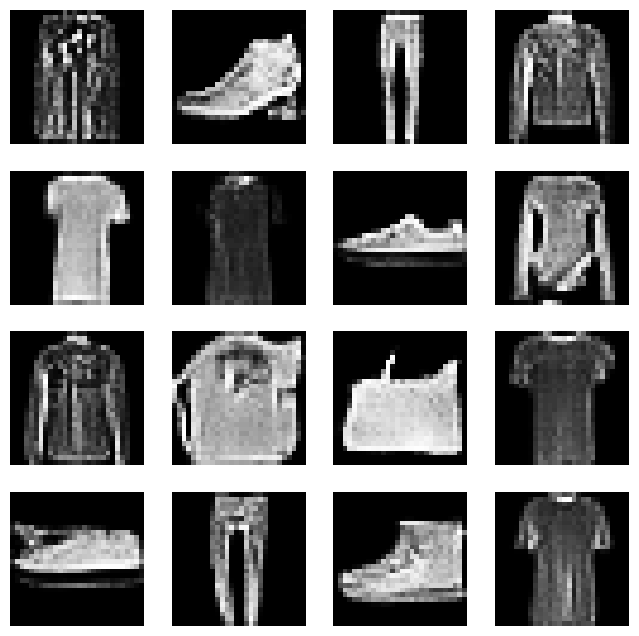

235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - d_loss: 1.3607 - g_loss: 0.7552
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3608 - g_loss: 0.7538
Epoch 13/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - d_loss: 1.3585 - g_loss: 0.7515
Epoch 14/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 139ms/step - d_loss: 1.3607 - g_loss: 0.7509
Epoch 15/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - d_loss: 1.3605 - g_loss: 0.7542
Epoch 16/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - d_loss: 1.3587 - g_loss: 0.7509

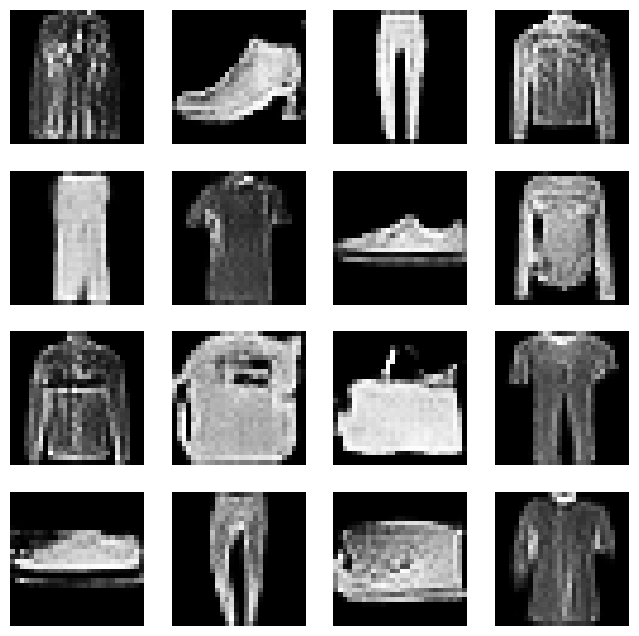

235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 140ms/step - d_loss: 1.3588 - g_loss: 0.7510
Epoch 17/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3569 - g_loss: 0.7483
Epoch 18/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - d_loss: 1.3605 - g_loss: 0.7532
Epoch 19/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3586 - g_loss: 0.7515
Epoch 20/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - d_loss: 1.3607 - g_loss: 0.7549
Epoch 21/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - d_loss: 1.3614 - g_loss: 0.7584

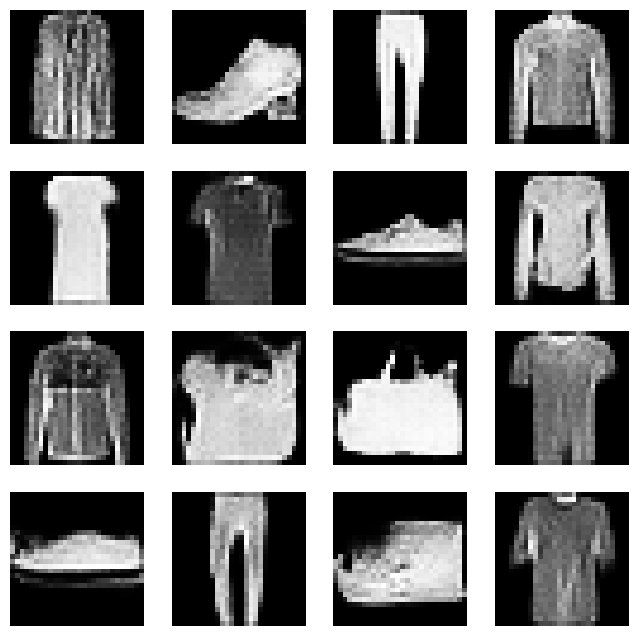

235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - d_loss: 1.3614 - g_loss: 0.7584
Epoch 22/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - d_loss: 1.3577 - g_loss: 0.7492
Epoch 23/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - d_loss: 1.3599 - g_loss: 0.7550
Epoch 24/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - d_loss: 1.3580 - g_loss: 0.7536
Epoch 25/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - d_loss: 1.3599 - g_loss: 0.7520
Epoch 26/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - d_loss: 1.3587 - g_loss: 0.7537

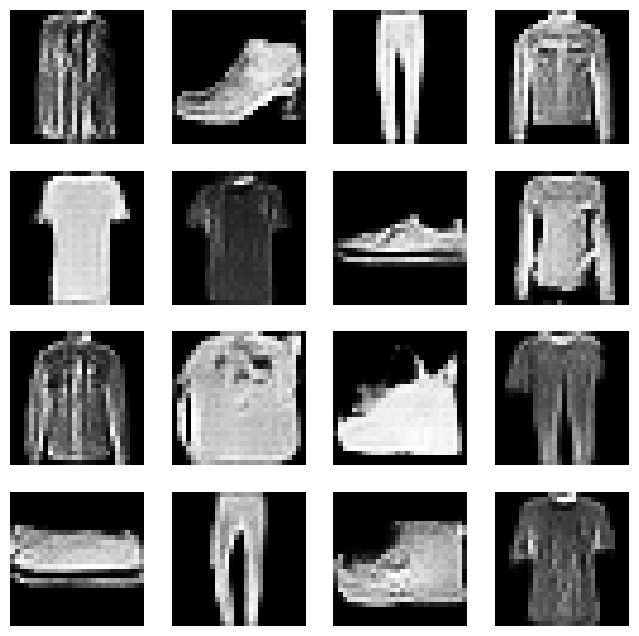

235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 141ms/step - d_loss: 1.3588 - g_loss: 0.7537
Epoch 27/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3564 - g_loss: 0.7518
Epoch 28/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - d_loss: 1.3584 - g_loss: 0.7544
Epoch 29/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3574 - g_loss: 0.7517
Epoch 30/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - d_loss: 1.3568 - g_loss: 0.7541
Epoch 31/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - d_loss: 1.3595 - g_loss: 0.7557

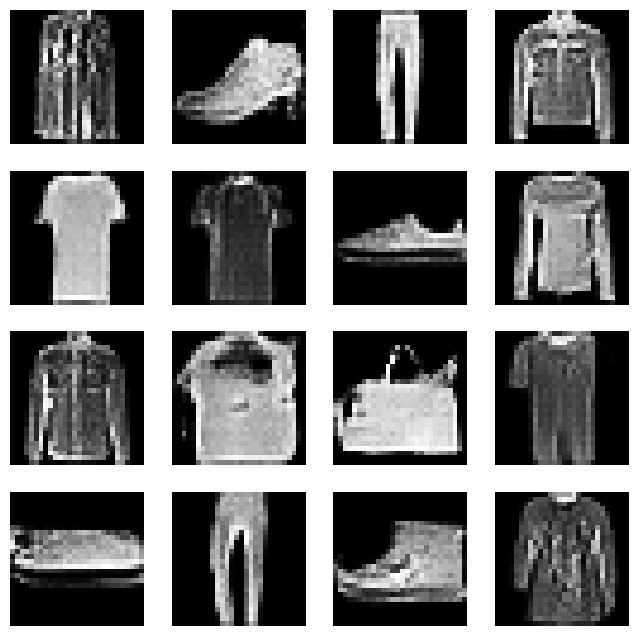

235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - d_loss: 1.3596 - g_loss: 0.7560
Epoch 32/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - d_loss: 1.3582 - g_loss: 0.7509
Epoch 33/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 139ms/step - d_loss: 1.3613 - g_loss: 0.7570
Epoch 34/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3577 - g_loss: 0.7522
Epoch 35/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - d_loss: 1.3557 - g_loss: 0.7511
Epoch 36/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - d_loss: 1.3575 - g_loss: 0.7587

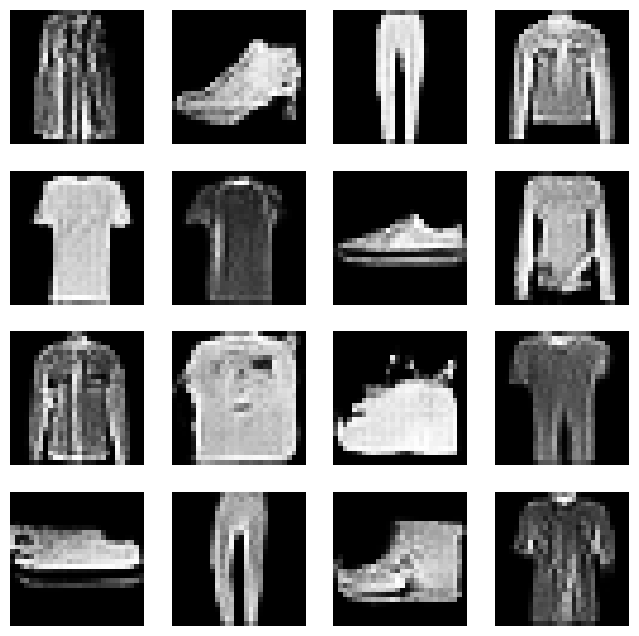

235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 140ms/step - d_loss: 1.3576 - g_loss: 0.7588
Epoch 37/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - d_loss: 1.3557 - g_loss: 0.7526
Epoch 38/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3583 - g_loss: 0.7544
Epoch 39/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - d_loss: 1.3563 - g_loss: 0.7514
Epoch 40/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3597 - g_loss: 0.7570
Epoch 41/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - d_loss: 1.3572 - g_loss: 0.7520

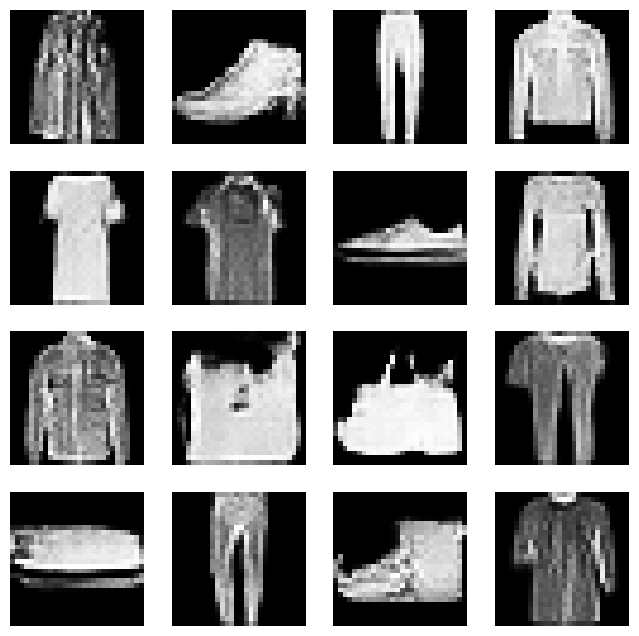

235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - d_loss: 1.3572 - g_loss: 0.7520
Epoch 42/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3566 - g_loss: 0.7532
Epoch 43/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3548 - g_loss: 0.7529
Epoch 44/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - d_loss: 1.3572 - g_loss: 0.7540
Epoch 45/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - d_loss: 1.3577 - g_loss: 0.7530
Epoch 46/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - d_loss: 1.3572 - g_loss: 0.7543

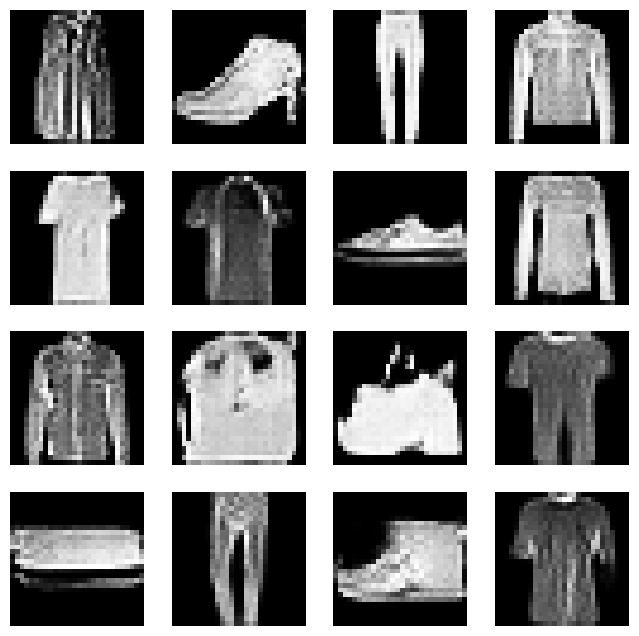

235/235 ━━━━━━━━━━━━━━━━━━━━ 33s 138ms/step - d_loss: 1.3573 - g_loss: 0.7541
Epoch 47/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - d_loss: 1.3584 - g_loss: 0.7550
Epoch 48/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3554 - g_loss: 0.7533
Epoch 49/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - d_loss: 1.3555 - g_loss: 0.7561
Epoch 50/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 137ms/step - d_loss: 1.3536 - g_loss: 0.7533


In [28]:
#TRAIN GAN MODEL
EPOCH = 50

history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()])

##evaluation

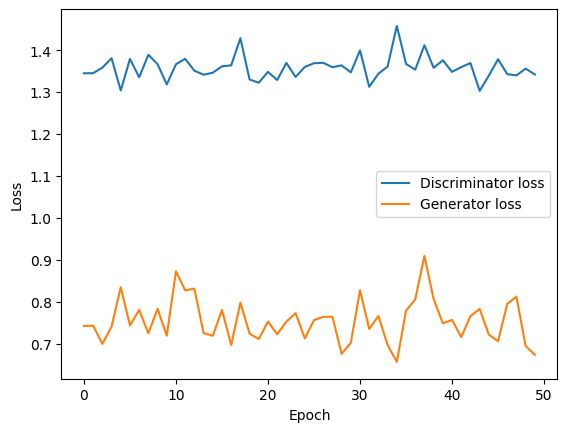

In [29]:

#evaluation
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [30]:

# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5 # denormalize


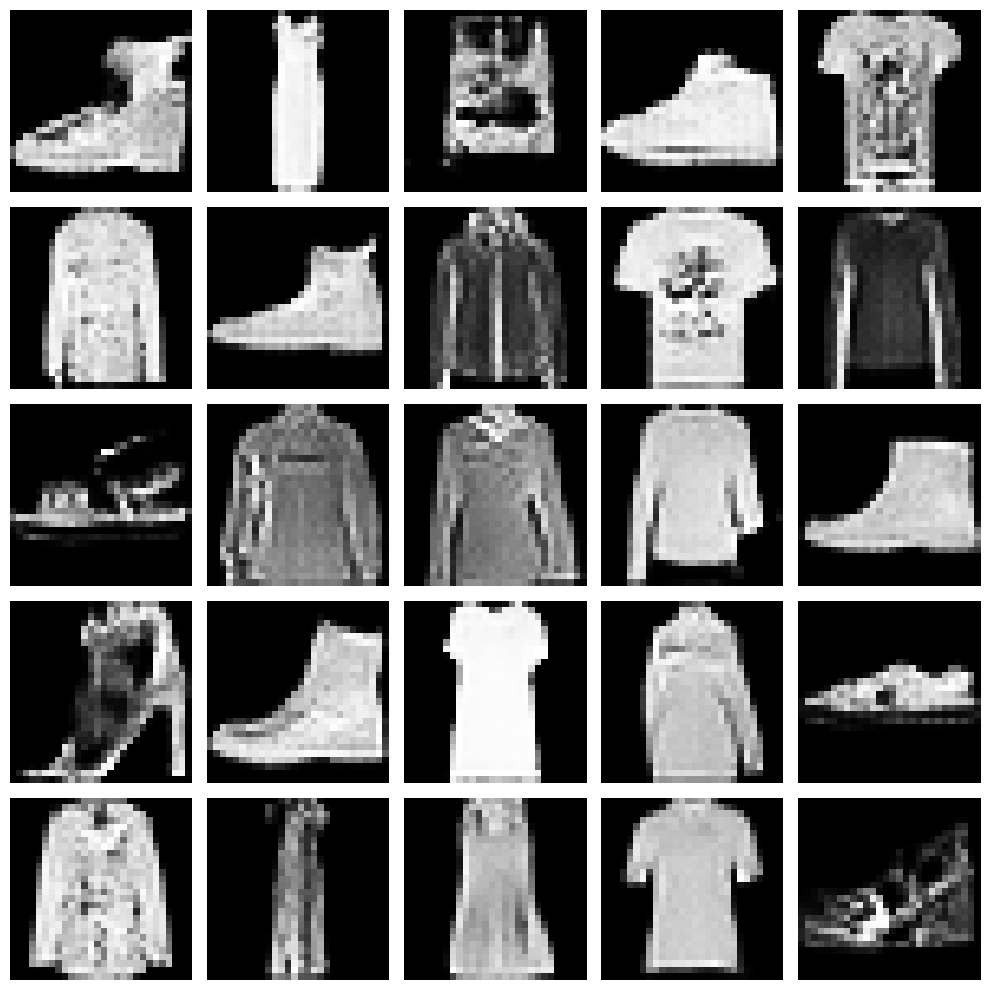

In [39]:

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
  plt.tight_layout()
  plt.savefig("fake_png")
plt.show()



from google.colab import drive
drive.mount('/content/drive')

generator.save("/content/drive/My Drive/fashion_gan_generator.h5")